In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from utils import plot_logits

## Plot Weights

In [2]:
data_4bit = np.load("layer_params_4bit.npy")[::2000]
data_8bit = np.load("layer_params_8bit.npy")
data_16bit = np.load("layer_params_fp16.npy")

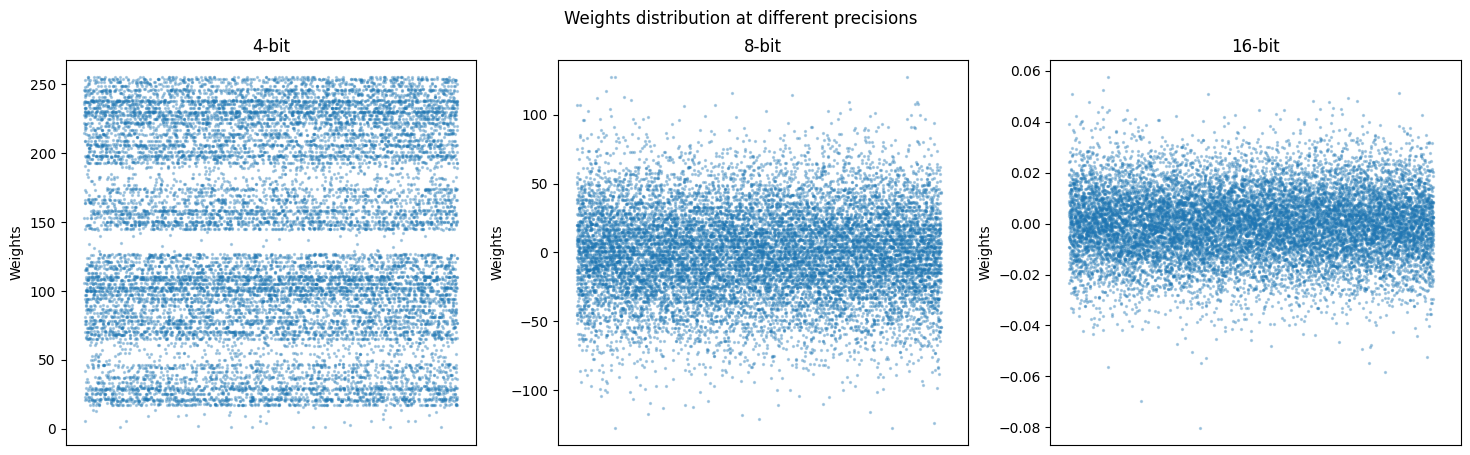

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
axes[0].scatter(x = range(len(data_4bit)), y = data_4bit, label = "8-bit", s=2, alpha=0.3)
axes[1].scatter(x = range(len(data_8bit)), y = data_8bit, label = "8-bit", s=2, alpha=0.3)
axes[2].scatter(x = range(len(data_16bit)), y = data_16bit, label = "8-bit", s=2, alpha=0.3)

axes[0].set_title("4-bit")
axes[1].set_title("8-bit")
axes[2].set_title("16-bit")
axes[0].set_ylabel("Weights")
axes[1].set_ylabel("Weights")
axes[2].set_ylabel("Weights")

# Remove x-axis
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[2].set_xticks([])

fig.suptitle("Weights distribution at different precisions")
fig.savefig("Weights_distribution_at_different_precisions.png")



In [4]:
# Print the min, max and number of unqiue values for each dataset
for data in [data_4bit, data_8bit, data_16bit]:
    print(f"Min: {np.min(data)}, Max: {np.max(data)}, Unique values: {len(np.unique(data))}, Dtype: {data.dtype}")




Min: 1, Max: 255, Unique values: 248, Dtype: uint8
Min: -127, Max: 127, Unique values: 229, Dtype: int8
Min: -0.080078125, Max: 0.057373046875, Unique values: 1942, Dtype: float16


In [5]:
data_8bit.dtype

dtype('int8')

## Plot Stats

In [6]:
df = pd.concat([pd.read_csv("model_stats_4bit.csv"), pd.read_csv("model_stats_8bit.csv"), pd.read_csv("model_stats_fp16.csv")])
df.index = ["4-bit", "8-bit", "16-bit"]
df = df.reset_index().rename(columns={"index": "Precision"})

In [7]:
df

,Precision,Peak Memory Allocated,Peak Memory Cached,Current Memory Allocated,Current Memory Cached,Num of Parameters
0,4-bit,5.769661,5.845703,5.769661,5.794922,4015263744
1,8-bit,8.626755,8.666016,8.587669,8.599609,7504924672
2,16-bit,15.082542,15.083984,15.082542,15.083984,7504924672


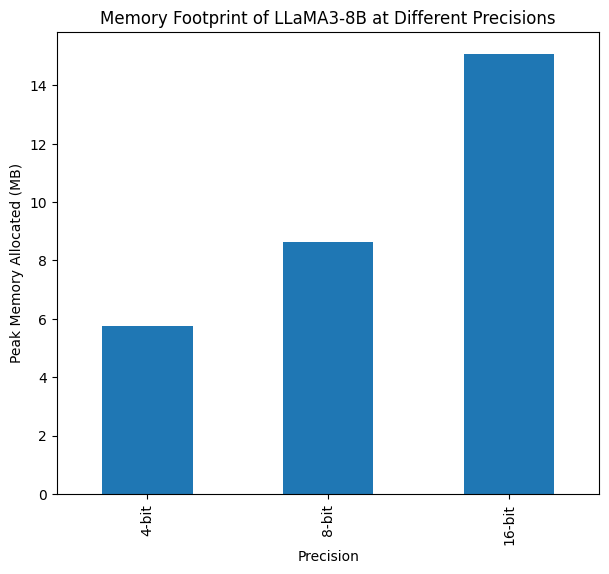

In [8]:
fig, ax = plt.subplots(figsize=(7, 6
                            ))
ax = df.plot(kind='bar', x='Precision', y='Peak Memory Allocated', ax=ax)
ax.set_ylabel("Peak Memory Allocated (MB)")
# hide legend
ax.get_legend().remove()
ax.set_title('Memory Footprint of LLaMA3-8B at Different Precisions')
fig.savefig("Memory_Footprint_of_LLaMA_3-8B_at_Different_Precisions")


## Plot Inference Time

In [9]:
df = pd.concat([pd.read_csv("output_4bit.csv"), pd.read_csv("output_8bit.csv"), pd.read_csv("output_fp16.csv")])

# Remove the first prompt
df = df[df['Prompt'] != "The Hitchhiker's Guide to the"]

df = df.groupby('Quantisation')['Inference_Time'].agg(['mean', 'std'])

df.index = ["4-bit", "8-bit", "16-bit"]
df.rename_axis('Quantisation', inplace=True)


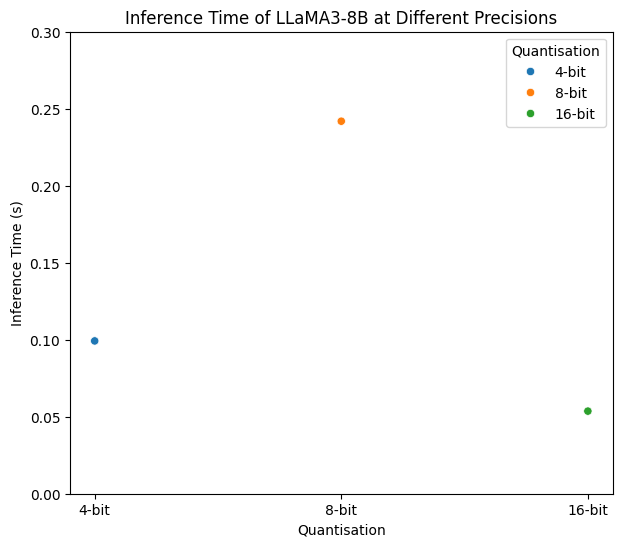

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.scatterplot(data=df, x='Quantisation', y='mean', hue=df.index, ax=ax)
ax.set_ylabel("Inference Time (s)")
ax.set_ylim(0, 0.3)
ax.set_title('Inference Time of LLaMA3-8B at Different Precisions')
fig.savefig("Inference_Time_of_LLaMA_3-8B_at_Different_Precisions")

## Plot Logits

In [11]:
df = pd.concat([pd.read_csv("output_4bit.csv"), pd.read_csv("output_8bit.csv"), pd.read_csv("output_fp16.csv")])

df

,n,Prompt,Top n Words,Top n Probabilities,Inference_Time,Model,Quantisation
0,1,The Hitchhiker's Guide to the,Galaxy,0.951033,0.628382,meta-llama/Meta-Llama-3-8B,4bit
1,2,The Hitchhiker's Guide to the,Universe,0.004688,0.628382,meta-llama/Meta-Llama-3-8B,4bit
2,3,The Hitchhiker's Guide to the,Galactic,0.001779,0.628382,meta-llama/Meta-Llama-3-8B,4bit
3,4,The Hitchhiker's Guide to the,Solar,0.001738,0.628382,meta-llama/Meta-Llama-3-8B,4bit
4,5,The Hitchhiker's Guide to the,British,0.001408,0.628382,meta-llama/Meta-Llama-3-8B,4bit
...,...,...,...,...,...,...,...
345,46,The most important thing in life is,people,0.001199,0.053131,meta-llama/Meta-Llama-3-8B,fp16
346,47,The most important thing in life is,God,0.001171,0.053131,meta-llama/Meta-Llama-3-8B,fp16
347,48,The most important thing in life is,good,0.001171,0.053131,meta-llama/Meta-Llama-3-8B,fp16
348,49,The most important thing in life is,integrity,0.001171,0.053131,meta-llama/Meta-Llama-3-8B,fp16


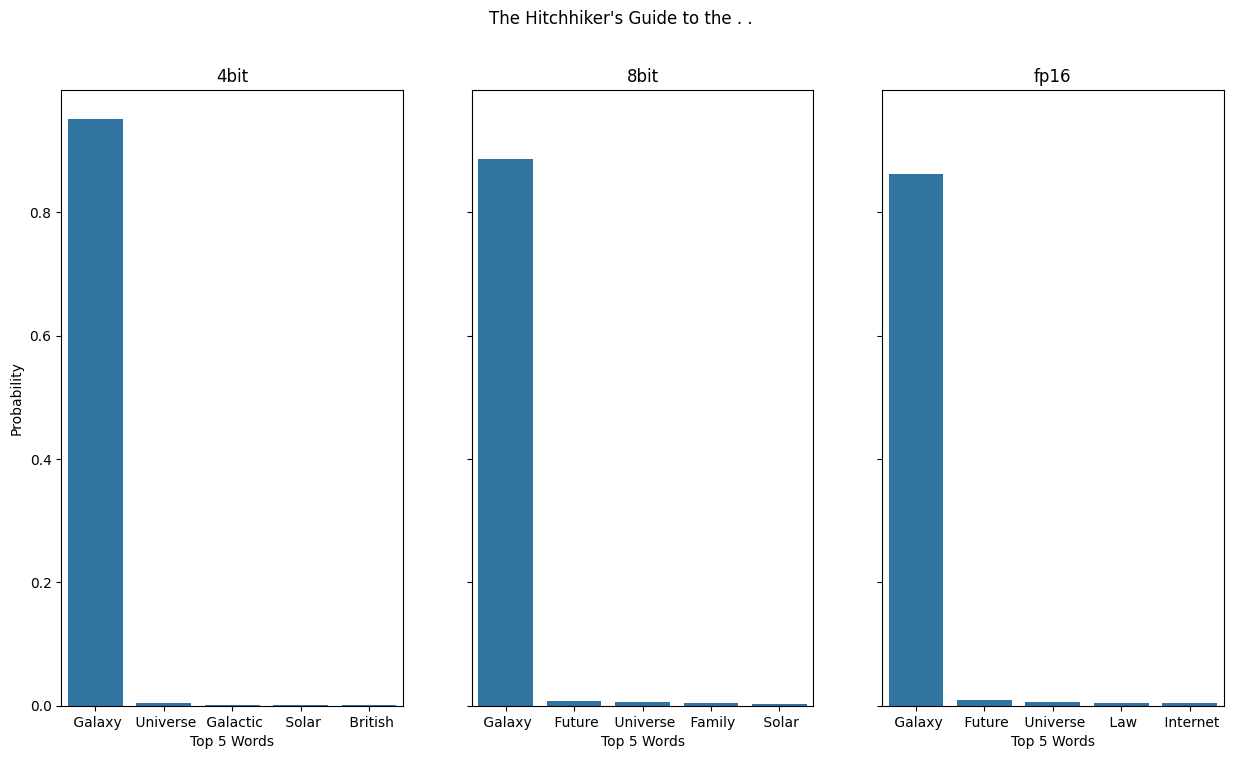

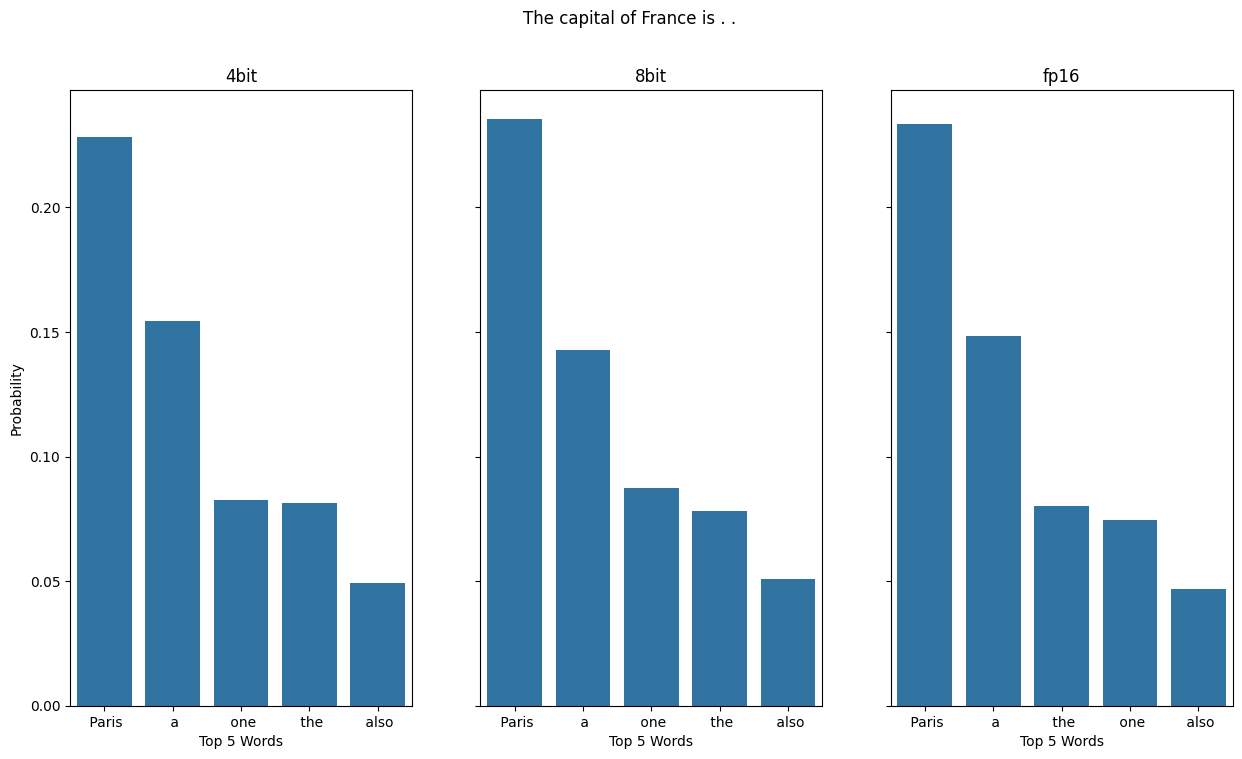

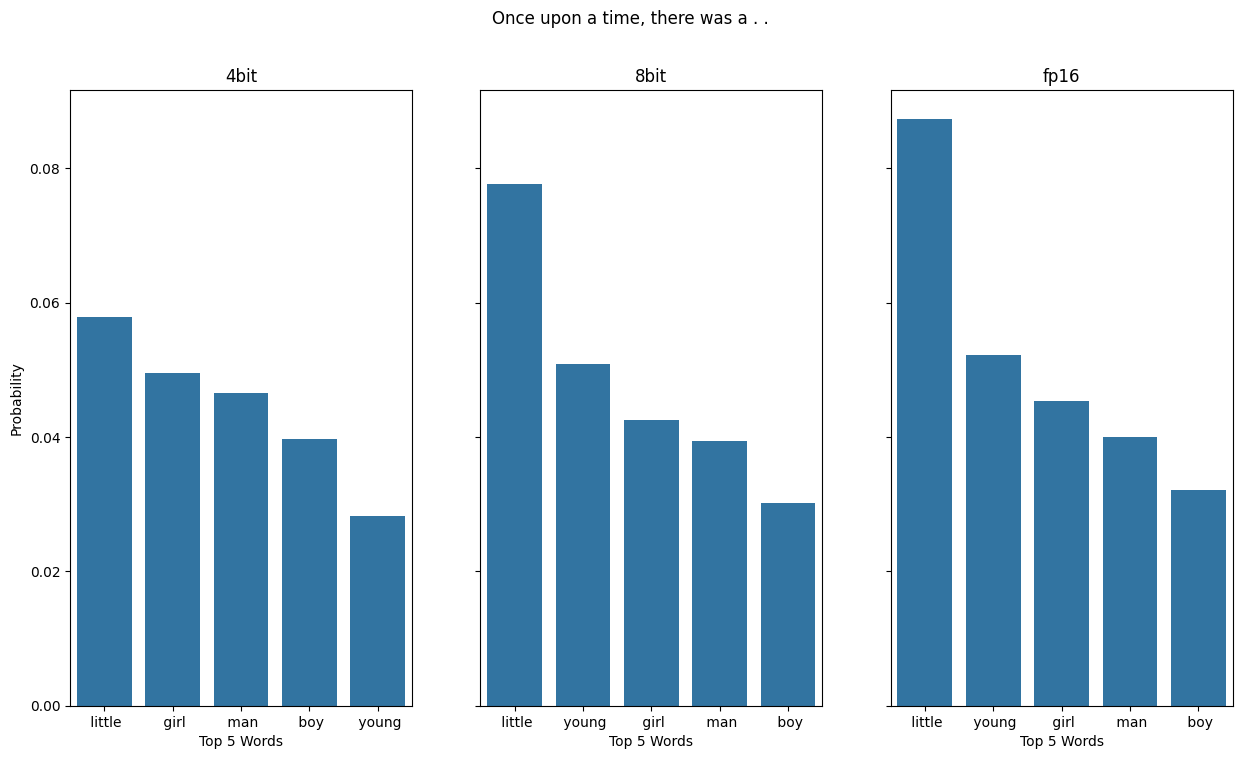

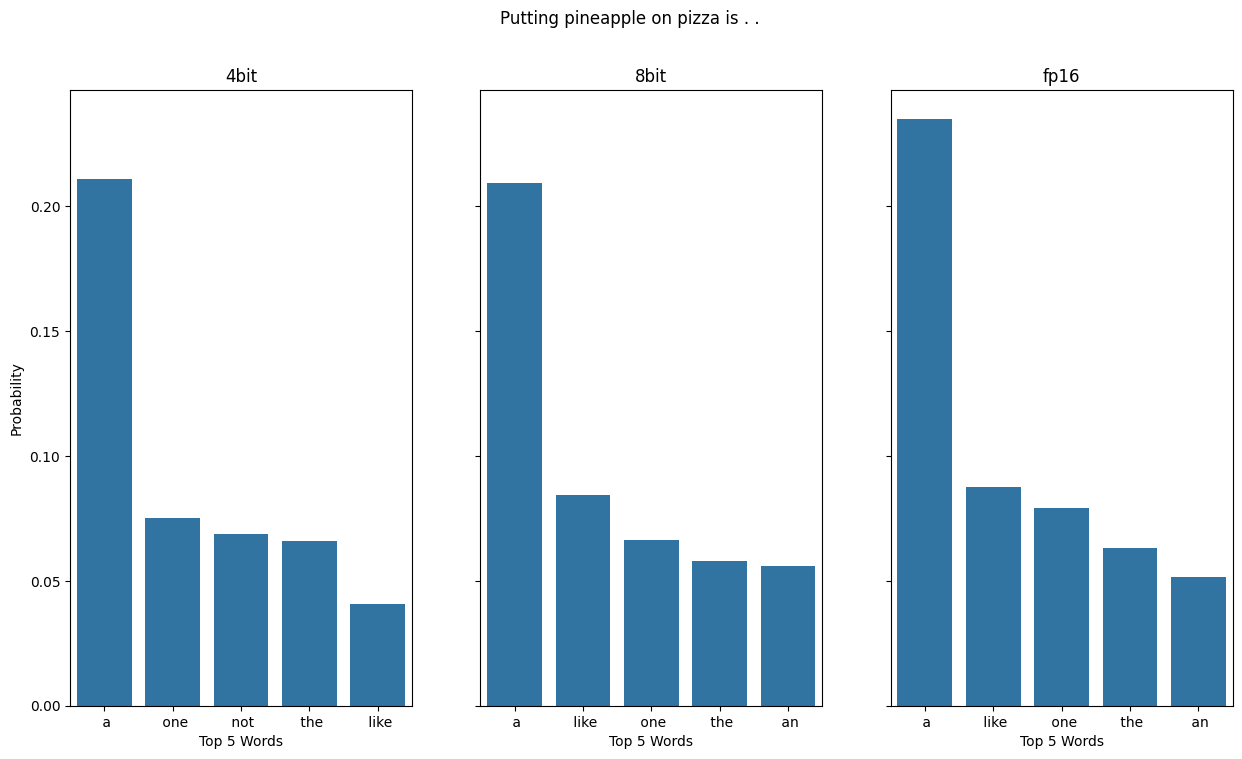

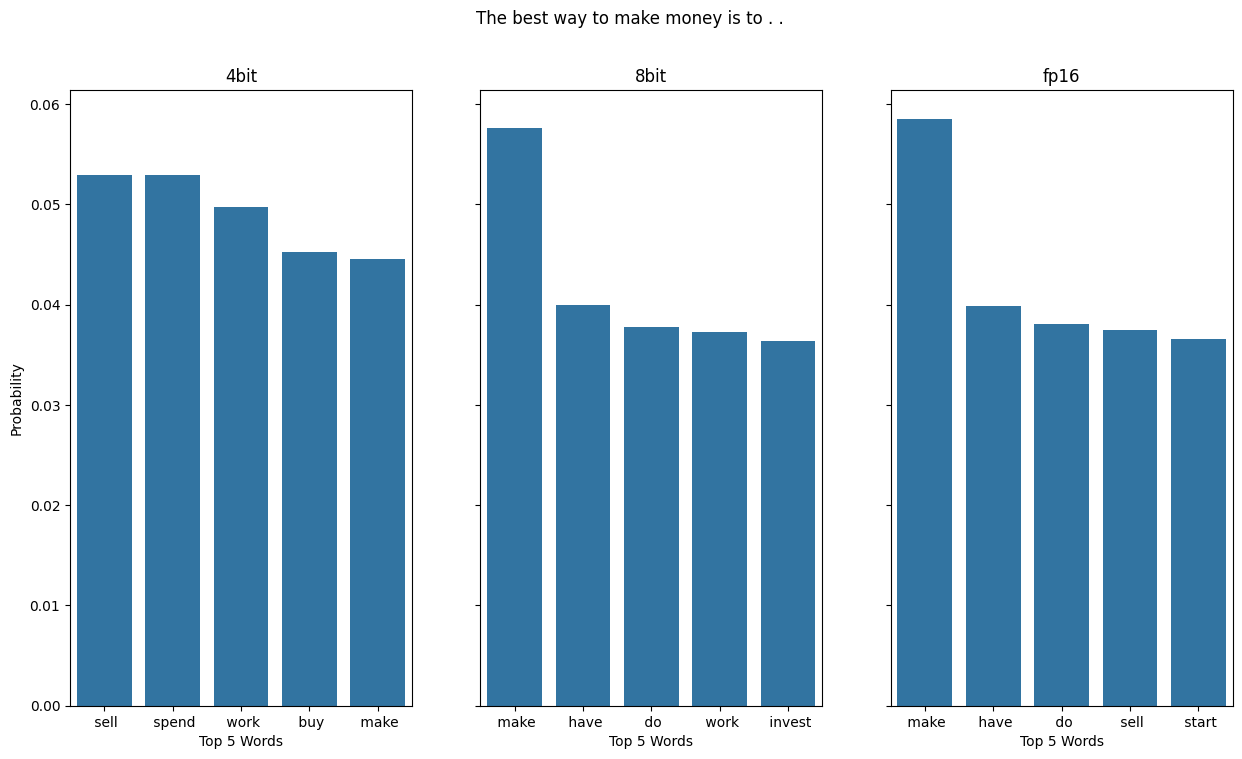

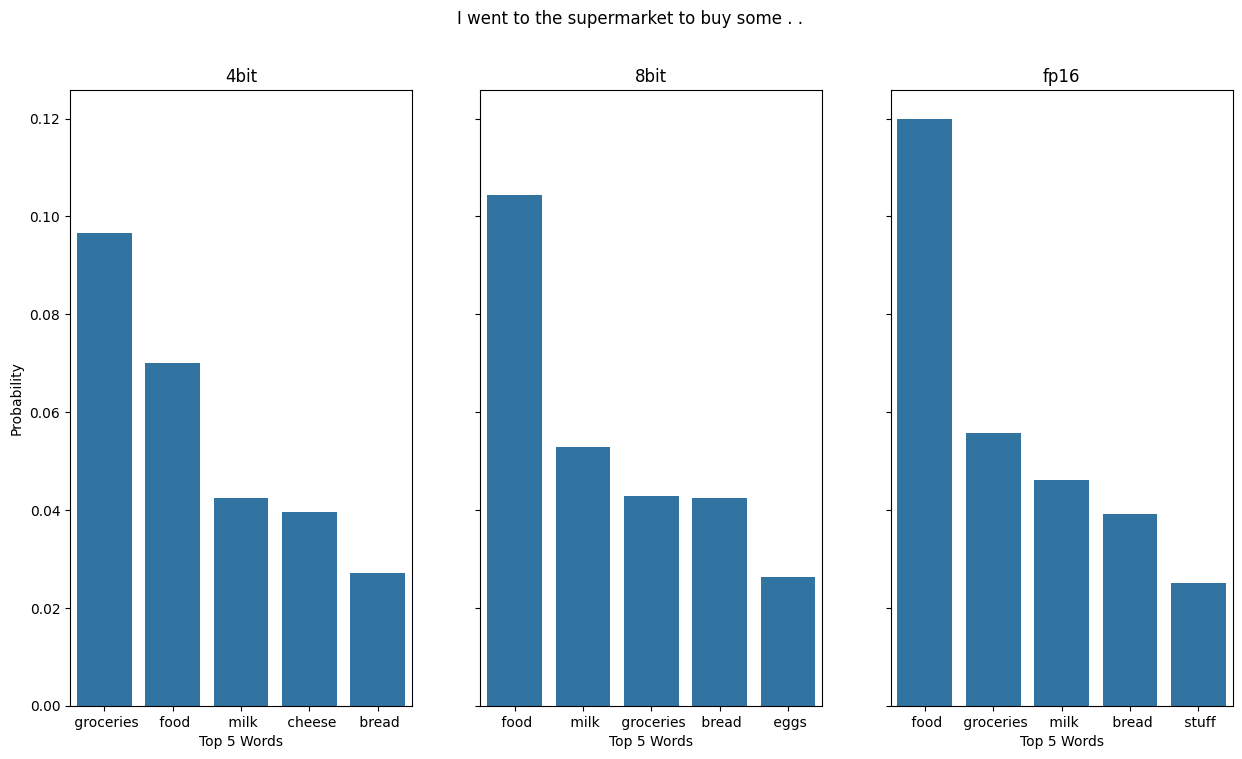

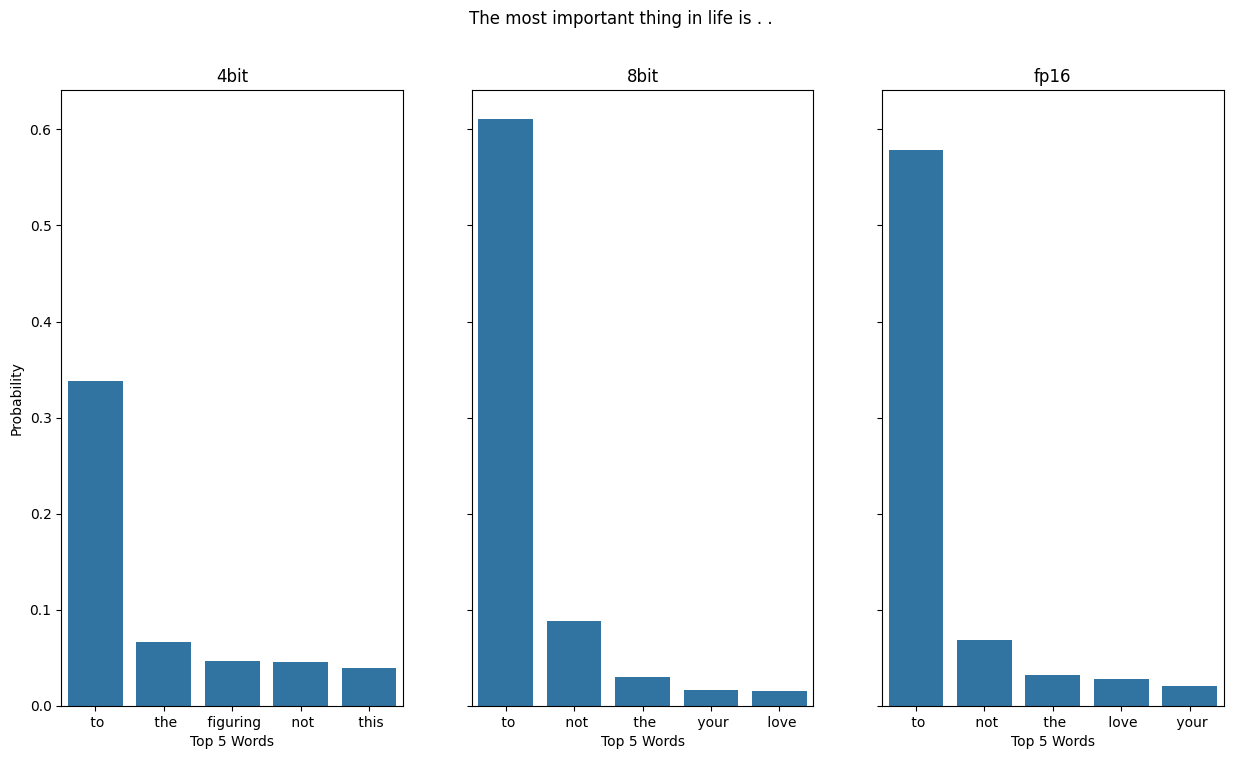

In [13]:
for prompt in df['Prompt'].unique():
    fig = plot_logits(df, prompt, figsize=(15, 8))
    fig.savefig(f"Logits_{prompt}.png")
